In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf

# Must come before any TensorFlow GPU initialization
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

2025-10-31 16:10:53.902118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761927054.105247      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761927054.163813      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Memory growth enabled for GPUs


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [4]:
train_images_dir = r"/kaggle/input/ai-vs-human-generated-dataset/train_data"
# test_images_dir = r"/kaggle/input/ai-vs-human-generated-dataset/test_data_v2"

# Custom paths to Read the CSV files (change as per your system settings or Kaggle notebook)
train_csv = pd.read_csv(r"/kaggle/input/ai-vs-human-generated-dataset/train.csv")
# test_csv = pd.read_csv(r"/kaggle/input/ai-vs-human-generated-dataset/test.csv")

In [5]:
train_csv= train_csv.drop(train_csv.columns[0], axis=1)
print(train_csv.head())
# print(test_csv.head())

                                         file_name  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


In [6]:
train_csv['file_name'] = train_csv['file_name'].str.replace('train_data/', '', regex=False)
print(train_csv.head())

                              file_name  label
0  a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  041be3153810433ab146bc97d5af505c.jpg      0
2  615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  8542fe161d9147be8e835e50c0de39cd.jpg      0
4  5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


In [7]:
train_csv['label'] = train_csv['label'].astype(str)

In [8]:
# test_csv['id'] = test_csv['id'].str.replace('test_data_v2/', '', regex=False)
# print(test_csv.head())

In [9]:
# train_data, val_data = train_test_split(train_csv, test_size=0.30, random_state=42) 
train_data, temp_data = train_test_split(train_csv, test_size=0.30, random_state=42, stratify=train_csv['label'])

# Split Temp into Validation (15%) and Test (15%)
val_data, test_data = train_test_split(temp_data, test_size=0.50, random_state=42, stratify=temp_data['label'])

In [10]:
IMG_SIZE = (224, 224)  # Resizing all the images
BATCH_SIZE = 32

# Data augmentation for training

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=(0.8,1.0),
    horizontal_flip=True
)

# Rescaling for validation and test data

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Training generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_images_dir,
    x_col='file_name',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Validation generator

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=train_images_dir,
    x_col='file_name',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Test generator

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=train_images_dir,
    x_col='file_name',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 55965 validated image filenames belonging to 2 classes.
Found 11992 validated image filenames belonging to 2 classes.
Found 11993 validated image filenames.


In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
def build_resnet50_model(input_shape=(224, 224, 3), train_base=False):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Fine-tune top 30% of layers
    if train_base:
        for layer in base_model.layers[:100]:
            layer.trainable = False
        for layer in base_model.layers[100:]:
            layer.trainable = True
    else:
        for layer in base_model.layers:
            layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [12]:
# Compile model (consistent with your Adam optimizer settings)
def compile_resnet_model(model):
    Adam_optimizer = Adam(learning_rate=0.001, beta_1=0.90, beta_2=0.90, epsilon=1e-10)
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam_optimizer,
        metrics=["accuracy"]
    )
    return model


In [13]:
# Train model for 20 epochs (no early stopping)
def train_resnet_model(model, train_gen, val_gen, epochs=20):
    """
    Trains the ResNet model for a fixed number of epochs.
    """
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs
    )
    return history

In [14]:
# Plot training curves (accuracy & loss)
def plot_training_curves(history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


I0000 00:00:1761927242.530304      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761927242.530972      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1761927257.026050      61 service.cc:148] XLA service 0x7a7fec002870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761927257.027052      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761927257.027076      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761927258.541269      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1749 ━━━━━━━━━━━━━━━━━━━━ 2:15 78ms/step - accuracy: 0.4844 - loss: 1.0825  

I0000 00:00:1761927263.322504      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1749/1749 ━━━━━━━━━━━━━━━━━━━━ 1183s 667ms/step - accuracy: 0.7671 - loss: 0.4960 - val_accuracy: 0.7864 - val_loss: 0.4841
Epoch 2/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 764s 437ms/step - accuracy: 0.8102 - loss: 0.4337 - val_accuracy: 0.8054 - val_loss: 0.4321
Epoch 3/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 749s 428ms/step - accuracy: 0.8167 - loss: 0.4239 - val_accuracy: 0.7826 - val_loss: 0.4492
Epoch 4/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 769s 440ms/step - accuracy: 0.8164 - loss: 0.4224 - val_accuracy: 0.8081 - val_loss: 0.4317
Epoch 5/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 739s 422ms/step - accuracy: 0.8228 - loss: 0.4133 - val_accuracy: 0.8115 - val_loss: 0.4257
Epoch 6/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 763s 436ms/step - accuracy: 0.8201 - loss: 0.4200 - val_accuracy: 0.8307 - val_loss: 0.3952
Epoch 7/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 741s 424ms/step - accuracy: 0.8235 - loss: 0.4129 - val_accuracy: 0.8290 - val_loss: 0.4052
Epoch 8/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 759s 434ms/step - accuracy: 0.

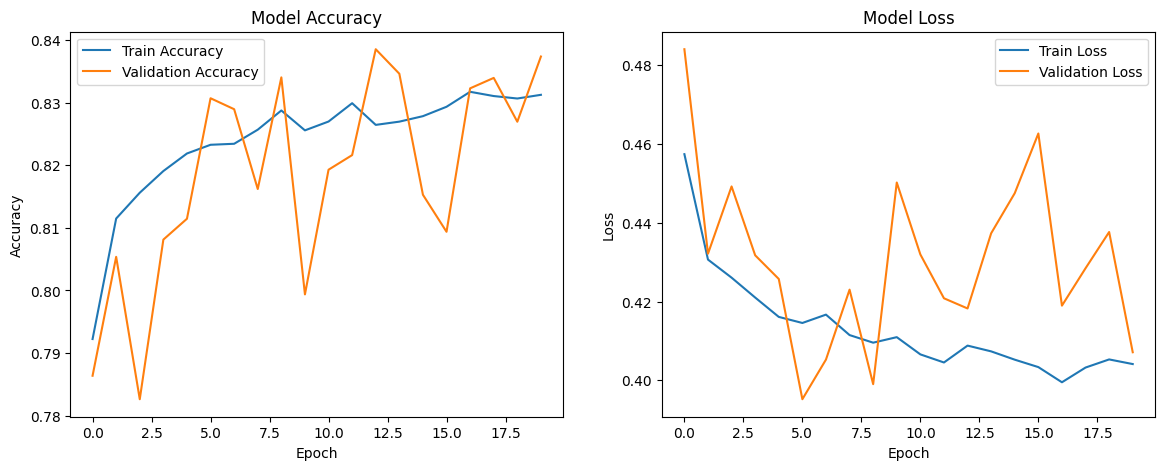

In [15]:
resnet_model = build_resnet50_model(input_shape=(224, 224, 3), train_base=False)
resnet_model = compile_resnet_model(resnet_model)

history = train_resnet_model(resnet_model, train_generator, val_generator, epochs=20)
plot_training_curves(history)
